# Анализ оттока клиентов

**Описание проекта.**

Проанализировать клиентов регионального банка и выделите сегменты клиентов, которые склонны уходить из банка.

В нашем распоряжении датасет bank_dataset.csv. Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

Заказчик исследования - менеджер продукта


**Цель исследования**

Минимизация оттока клиентов банка на основе анализа их поведения, которая включает в себя: -исследование факторов, усиливающих отток клиентов и удерживающих клиентов в банке, проверка гипотез.


# Содержание

1. Обзор данных
2. Предобработка данных
3. Исследовательский анализ данных
4. Проверка гипотез
5. Сегментация

## Обзор данных

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

Колонки:

- userid — идентификатор пользователя,
- score — баллы кредитного скоринга,
- City — город,
- Gender — пол,
- Age — возраст,
- Objects — количество объектов в собственности,
- Balance — баланс на счёте,
- Products — количество продуктов, которыми пользуется клиент,
- CreditCard — есть ли кредитная карта,
- Loyalty — активный клиент,
- estimated_salary — заработная плата клиента,
- Churn — ушёл или нет.

In [2]:
#загрузка необходимых библиотек для исследования

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns 

from matplotlib import rcParams

import scipy.stats as st
import math as mth

import statistics as stat

import phik
from phik.report import plot_correlation_matrix
from phik import report
    
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score

In [3]:
#загрузка данных
df = pd.read_csv('https://code.s3.yandex.net/datasets/bank_dataset.csv')
    
df.head()

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


In [4]:
# параметры формата
pd.set_option('display.float_format', '{:.2f}'.format)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [6]:
# типы данных в датасете
df.dtypes

userid                int64
score                 int64
City                 object
Gender               object
Age                   int64
Objects               int64
Balance             float64
Products              int64
CreditCard            int64
Loyalty               int64
estimated_salary    float64
Churn                 int64
dtype: object

Типы данных в датасете корректны, замены не требуется

Посчитаем кол-во и долю пропусков в стоблце balance

In [7]:
print('Всего пропусков в столбце balance: {}'.format(df.isna().sum().sort_values(ascending=False)[0]))
print('Пропущено {}% значений в столбце balance'.format((df.isna().sum().sort_values(ascending=False)[0])*100/len(df)))

Всего пропусков в столбце balance: 3617
Пропущено 36.17% значений в столбце balance


**Вывод:**

В представленном для анализа файле 10000 строк с данными клиентов банка.

Таблица содержит 12 столбцов:

- userid — идентификатор пользователя,
- score — баллы кредитного скоринга,
- City — город,
- Gender — пол,
- Age — возраст,
- Objects — количество объектов в собственности,
- Balance — баланс на счёте
- Products — количество продуктов, которыми пользуется клиент,
- CreditCard — есть ли кредитная карта
- Loyalty — активный клиент,
- est_salary — заработная плата клиента,
- Churn — признак оттока: ушёл или нет

В поле Balance - 3617 пропусков данных, что составляет 36.17% от общего количества данных.

Предварительно можно утверждать, что, данных достаточно для анализа.

На этапе предобработки внесем следующие изменения:

- исправим нарушения стиля (приведем к snacke_case и заменим прописные буквы в наименованиях столбцов на строчные);

- заменим значения стоблца Gender с "Ж" на 0, с "М" на 1;

- проанализируем столбец Balance для принятия решения о работе с пропусками данных.

- проверим данные на дубликаты.

## Предобработка данных

**Приведем наименование столбцов файлов к единому стилю**

In [8]:
#перевод в нижний регистр:
df.columns = df.columns.str.lower()
print(df.columns) 

Index(['userid', 'score', 'city', 'gender', 'age', 'objects', 'balance',
       'products', 'creditcard', 'loyalty', 'estimated_salary', 'churn'],
      dtype='object')


In [9]:
#перевод столбца userid к snacke_case:
df = df.rename(columns={'userid':'user_id', 'creditcard':'credit_card'})
print(df.columns)

Index(['user_id', 'score', 'city', 'gender', 'age', 'objects', 'balance',
       'products', 'credit_card', 'loyalty', 'estimated_salary', 'churn'],
      dtype='object')


**Замена значений столбца gender**

In [10]:
print("Значения до замены:", '\n', df['gender'].value_counts())

#замена значений "М" на 1, "Ж" на 0:
df.loc[df['gender']=='М', 'gender'] = 1
df.loc[df['gender']=='Ж','gender'] = 0

#приведем к типу данных int:
df['gender'] = df['gender'].astype(int)

print("Значения после замены:", '\n', df['gender'].value_counts())

Значения до замены: 
 М    5457
Ж    4543
Name: gender, dtype: int64
Значения после замены: 
 1    5457
0    4543
Name: gender, dtype: int64


**Анализ пропусков столбца balance**

Рассмотрим подробнее строки с пропусками данных в поле balance. Их много (36.17% от общего количества данных), поэтому удалить их будет некорректно

In [11]:
df['balance'].describe().to_frame()

,balance
count,6383.00
mean,119827.49
std,30095.06
min,3768.69
25%,100181.98
50%,119839.69
75%,139512.29
max,250898.09


Проведем небольшие вычисления:

Распределение пропусков данных по филиалам:

In [12]:
df.query('balance.isna()').groupby('city')['city'].count()

city
Рыбинск      1199
Ярославль    2418
Name: city, dtype: int64

Больше всего пропусков в Ярославле

Проверим датафрейм на скрытые дубликаты. Достаточно посмотреть дубликаты столбца estimated_salary

In [13]:
df['estimated_salary'].duplicated().sum()

1

Одно совпавшее значения из 10 тыс. скорее случайность. Поскольку дубликаты отсутствуют, причина пропусков не в том, что часть данных случайно загружена в датасет дважды.

In [14]:
#группируем строки с пропусками по значениям оттока (0/1)
df.query('balance.isna()').groupby('churn')['churn'].count()

churn
0    3117
1     500
Name: churn, dtype: int64

В строках с пропусками значений есть клиенты как ушедшие, так и оставшиеся в банке, а наличие/отсутствие остатка не связано churn=1, то есть пропуск не является признаком оттока

In [15]:
#проверяем, есть ли нулевые остатки в поле `balance`
df.query('balance == 0')

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn


Нулевых остатков в датасете нет, что косвенно подтверждает предположение о том, что пропуски- это нулевые значения

**Вывод:**

- пропуски не связаны с признаком оттока, т.е. присутствуют и у ушедших, и у действующих клиентов;
- у клиентов с признаком оттока существуют остатки на счетах;
- пропуски данных есть только в записях о клиентах из Рыбинска и Ярославля.
- нет зависимости наличия пропуска от какого-либо другого признака.

В реальном исследовании для корректности анализа стоит связаться с заказчиком и обговорить алгоритм формирования данных для анализа. Но в нашем случае это невозможно, поэтому мы предположим, что пропуски поля balance- это нулевые остатки. Поэтому во избежание искажения анализа мы не будем удалять строки с пропусками (т.к.это 36.17% датасета), и не будем заменять пропуски на нули (т.к.это исказит данные поля balance).

**Проверим данные на наличие дубликатов**

In [16]:
# проверка на наличие явных дубликатов
df.duplicated().sum()

0

**Общий вывод по пункту**

В результате предобработки данных:

- наименования столбцов приведены к общему стилю
- проведена замена значений поля gender с "М" на 1 и с "Ж" на 0
- пропуски данных поля balance во избежание искажения дальнейшего анализа оставлены без изменений

## Исследовательский анализ данных

### Метрики и распределения данных

Посмотрим значения ключевых метрик для имеющихся данных.

In [17]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,10000.00,15733676.57,71936.19,15608437.00,15671264.25,15733474.00,15795969.75,15858426.00
score,10000.00,650.53,96.65,350.00,584.00,652.00,718.00,850.00
gender,10000.00,0.55,0.50,0.00,0.00,1.00,1.00,1.00
age,10000.00,38.92,10.49,18.00,32.00,37.00,44.00,92.00
objects,10000.00,5.01,2.89,0.00,3.00,5.00,7.00,10.00
balance,6383.00,119827.49,30095.06,3768.69,100181.98,119839.69,139512.29,250898.09
products,10000.00,1.53,0.58,1.00,1.00,1.00,2.00,4.00
credit_card,10000.00,0.71,0.46,0.00,0.00,1.00,1.00,1.00
loyalty,10000.00,0.52,0.50,0.00,0.00,1.00,1.00,1.00
estimated_salary,10000.00,100090.24,57510.49,11.58,51002.11,100193.91,149388.25,199992.48


Можно отметить следующее:

- возраст клиентов банка чаще всего от 32 до 44 лет, но встречаются граждане 18 и 92 лет;
- доход клиентов в большинстве случаев варьируется от 51 до 149 тысяч, в среднем около 100 тысяч, ;
- кредитный рейтинг довольно неплохой в среднем около 650.

Построим графики распределения

Для категориальных величин:

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seab

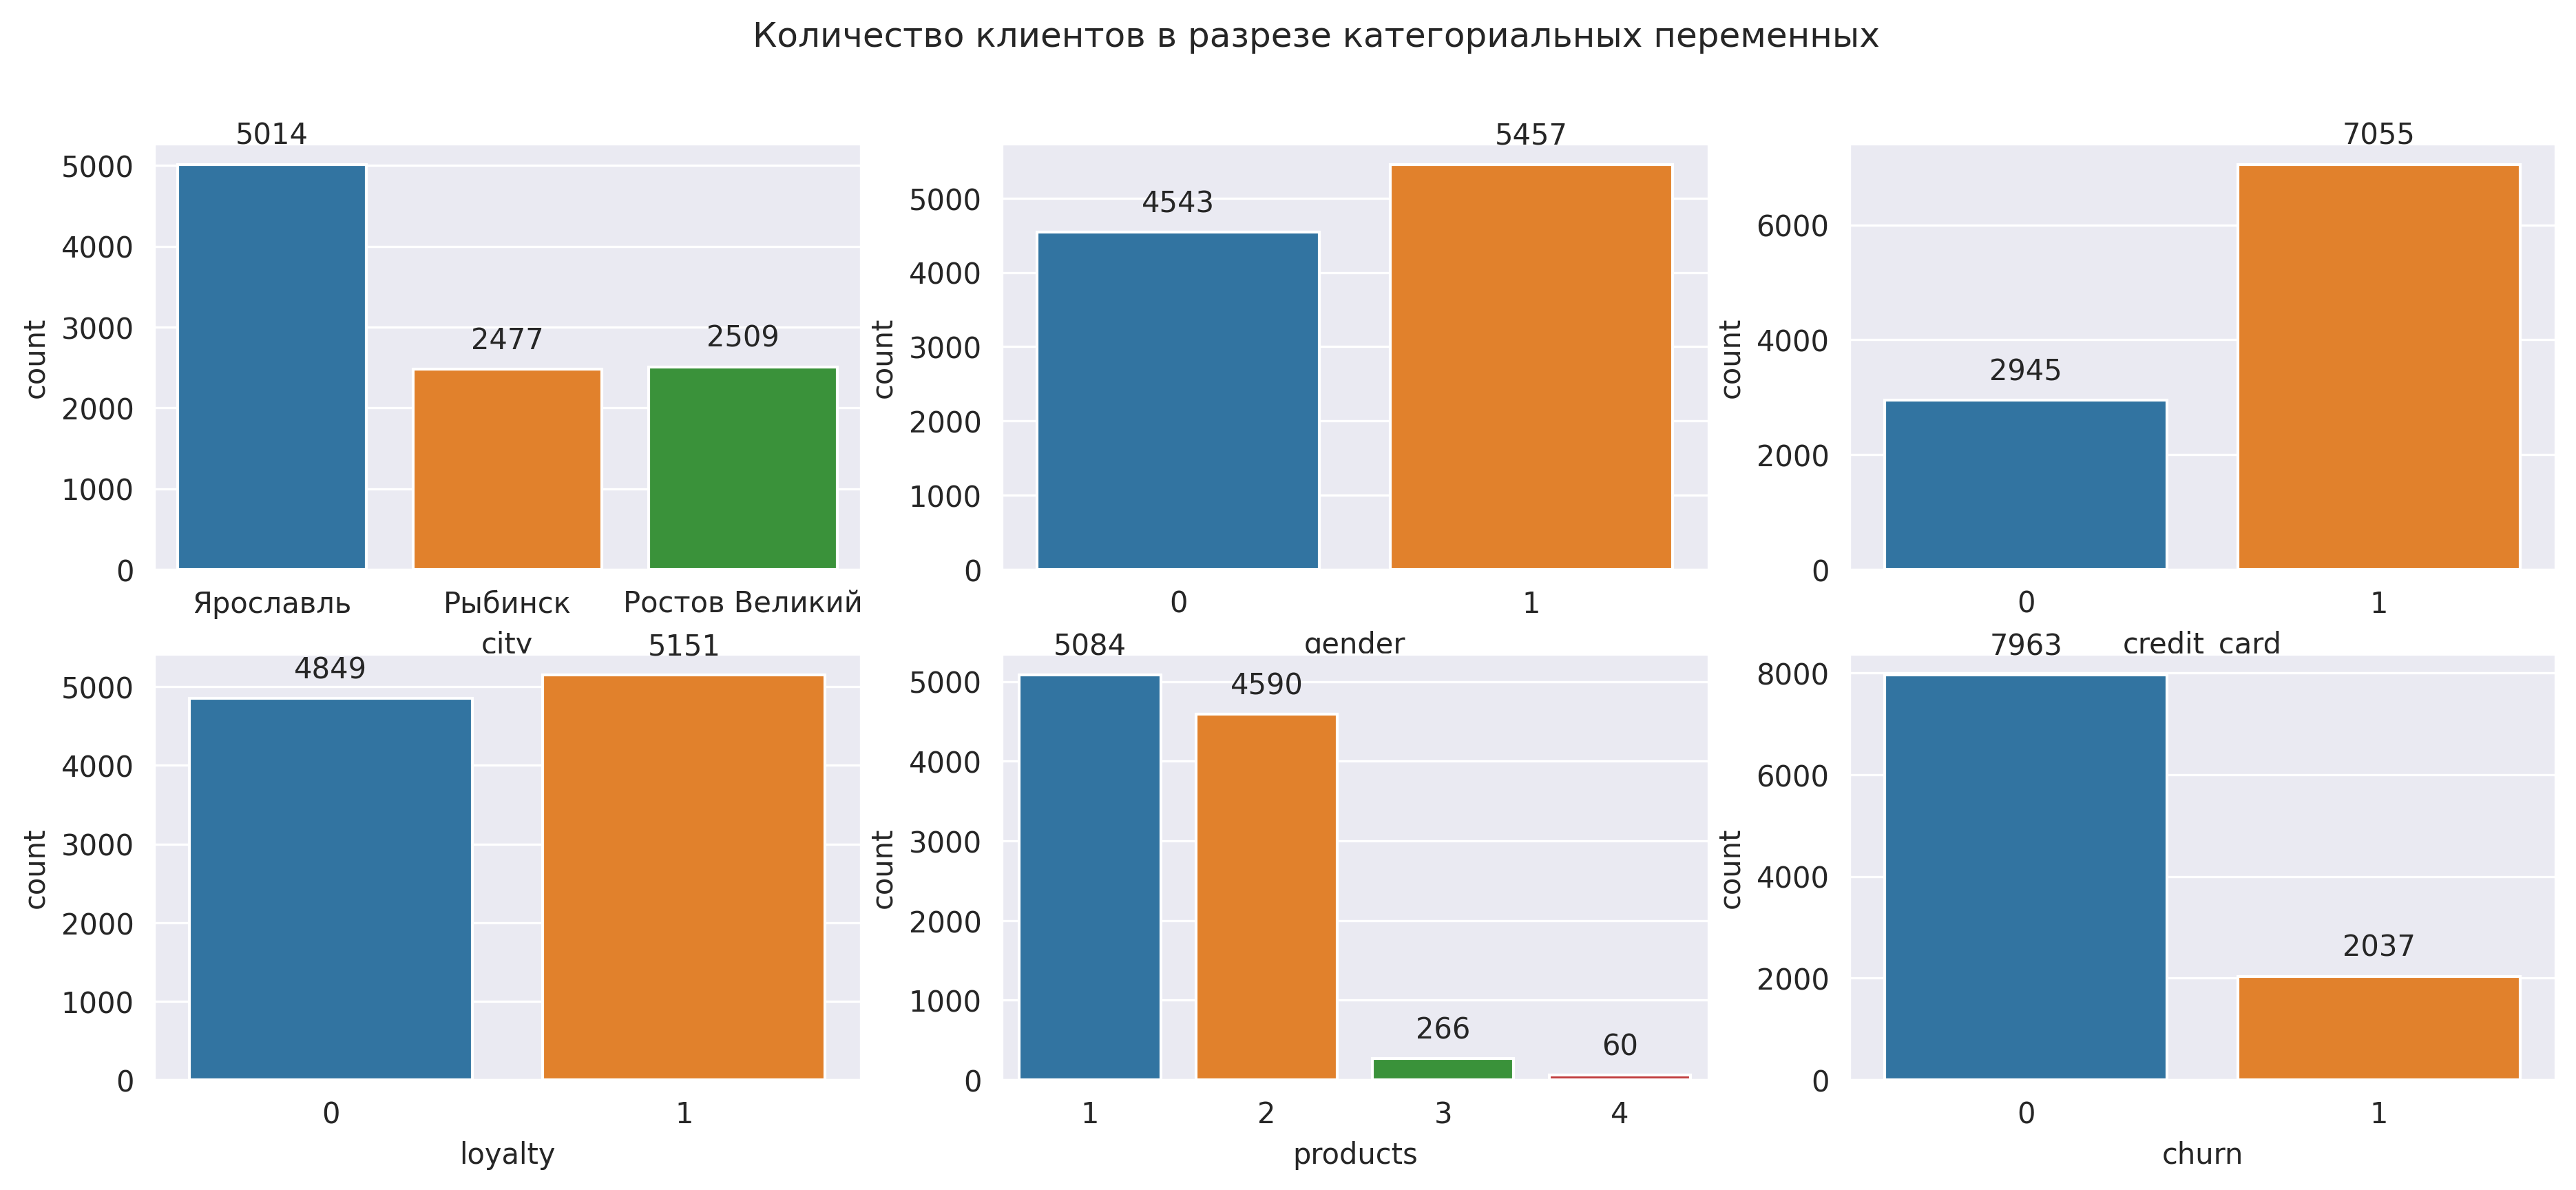

In [18]:
sns.set_style("darkgrid")
column_list = ['city', 'gender', 'credit_card', 'loyalty', 'products', 'churn']

fig, ax = plt.subplots(2, 3)
fig.set_size_inches(15, 6) 
fig.set_dpi(300)
for variable, subplot in zip(column_list, ax.flatten()):
    splot = sns.countplot(df[variable], ax=subplot)
    for p in splot.patches:
        splot.annotate('{:.0f}'.format(p.get_height()), (p.get_x() + p.get_width()/2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
fig.suptitle("Количество клиентов в разрезе категориальных переменных");
fig.show('png')

**Вывод:**

- В Ярославле гораздо больше клиентов, чем в Рыбинске и Ростове;
- мужчин и женщин практически поровну (мужчин немного больше);
- владельцев кредитных карт в 2 раза больше, чем клиентов не пользующихся кредитной картой;
- клиентов совершают какие-либо действия в приложении и не делающих этого практически поровну;
- в выборке есть клиенты с 1,2,3 и 4 продуктами банка, преобладают с 1 или 2, преимущественно с 1;
- отток клиентов довольно большой.

Построим графики распределения

Для количественных величин:

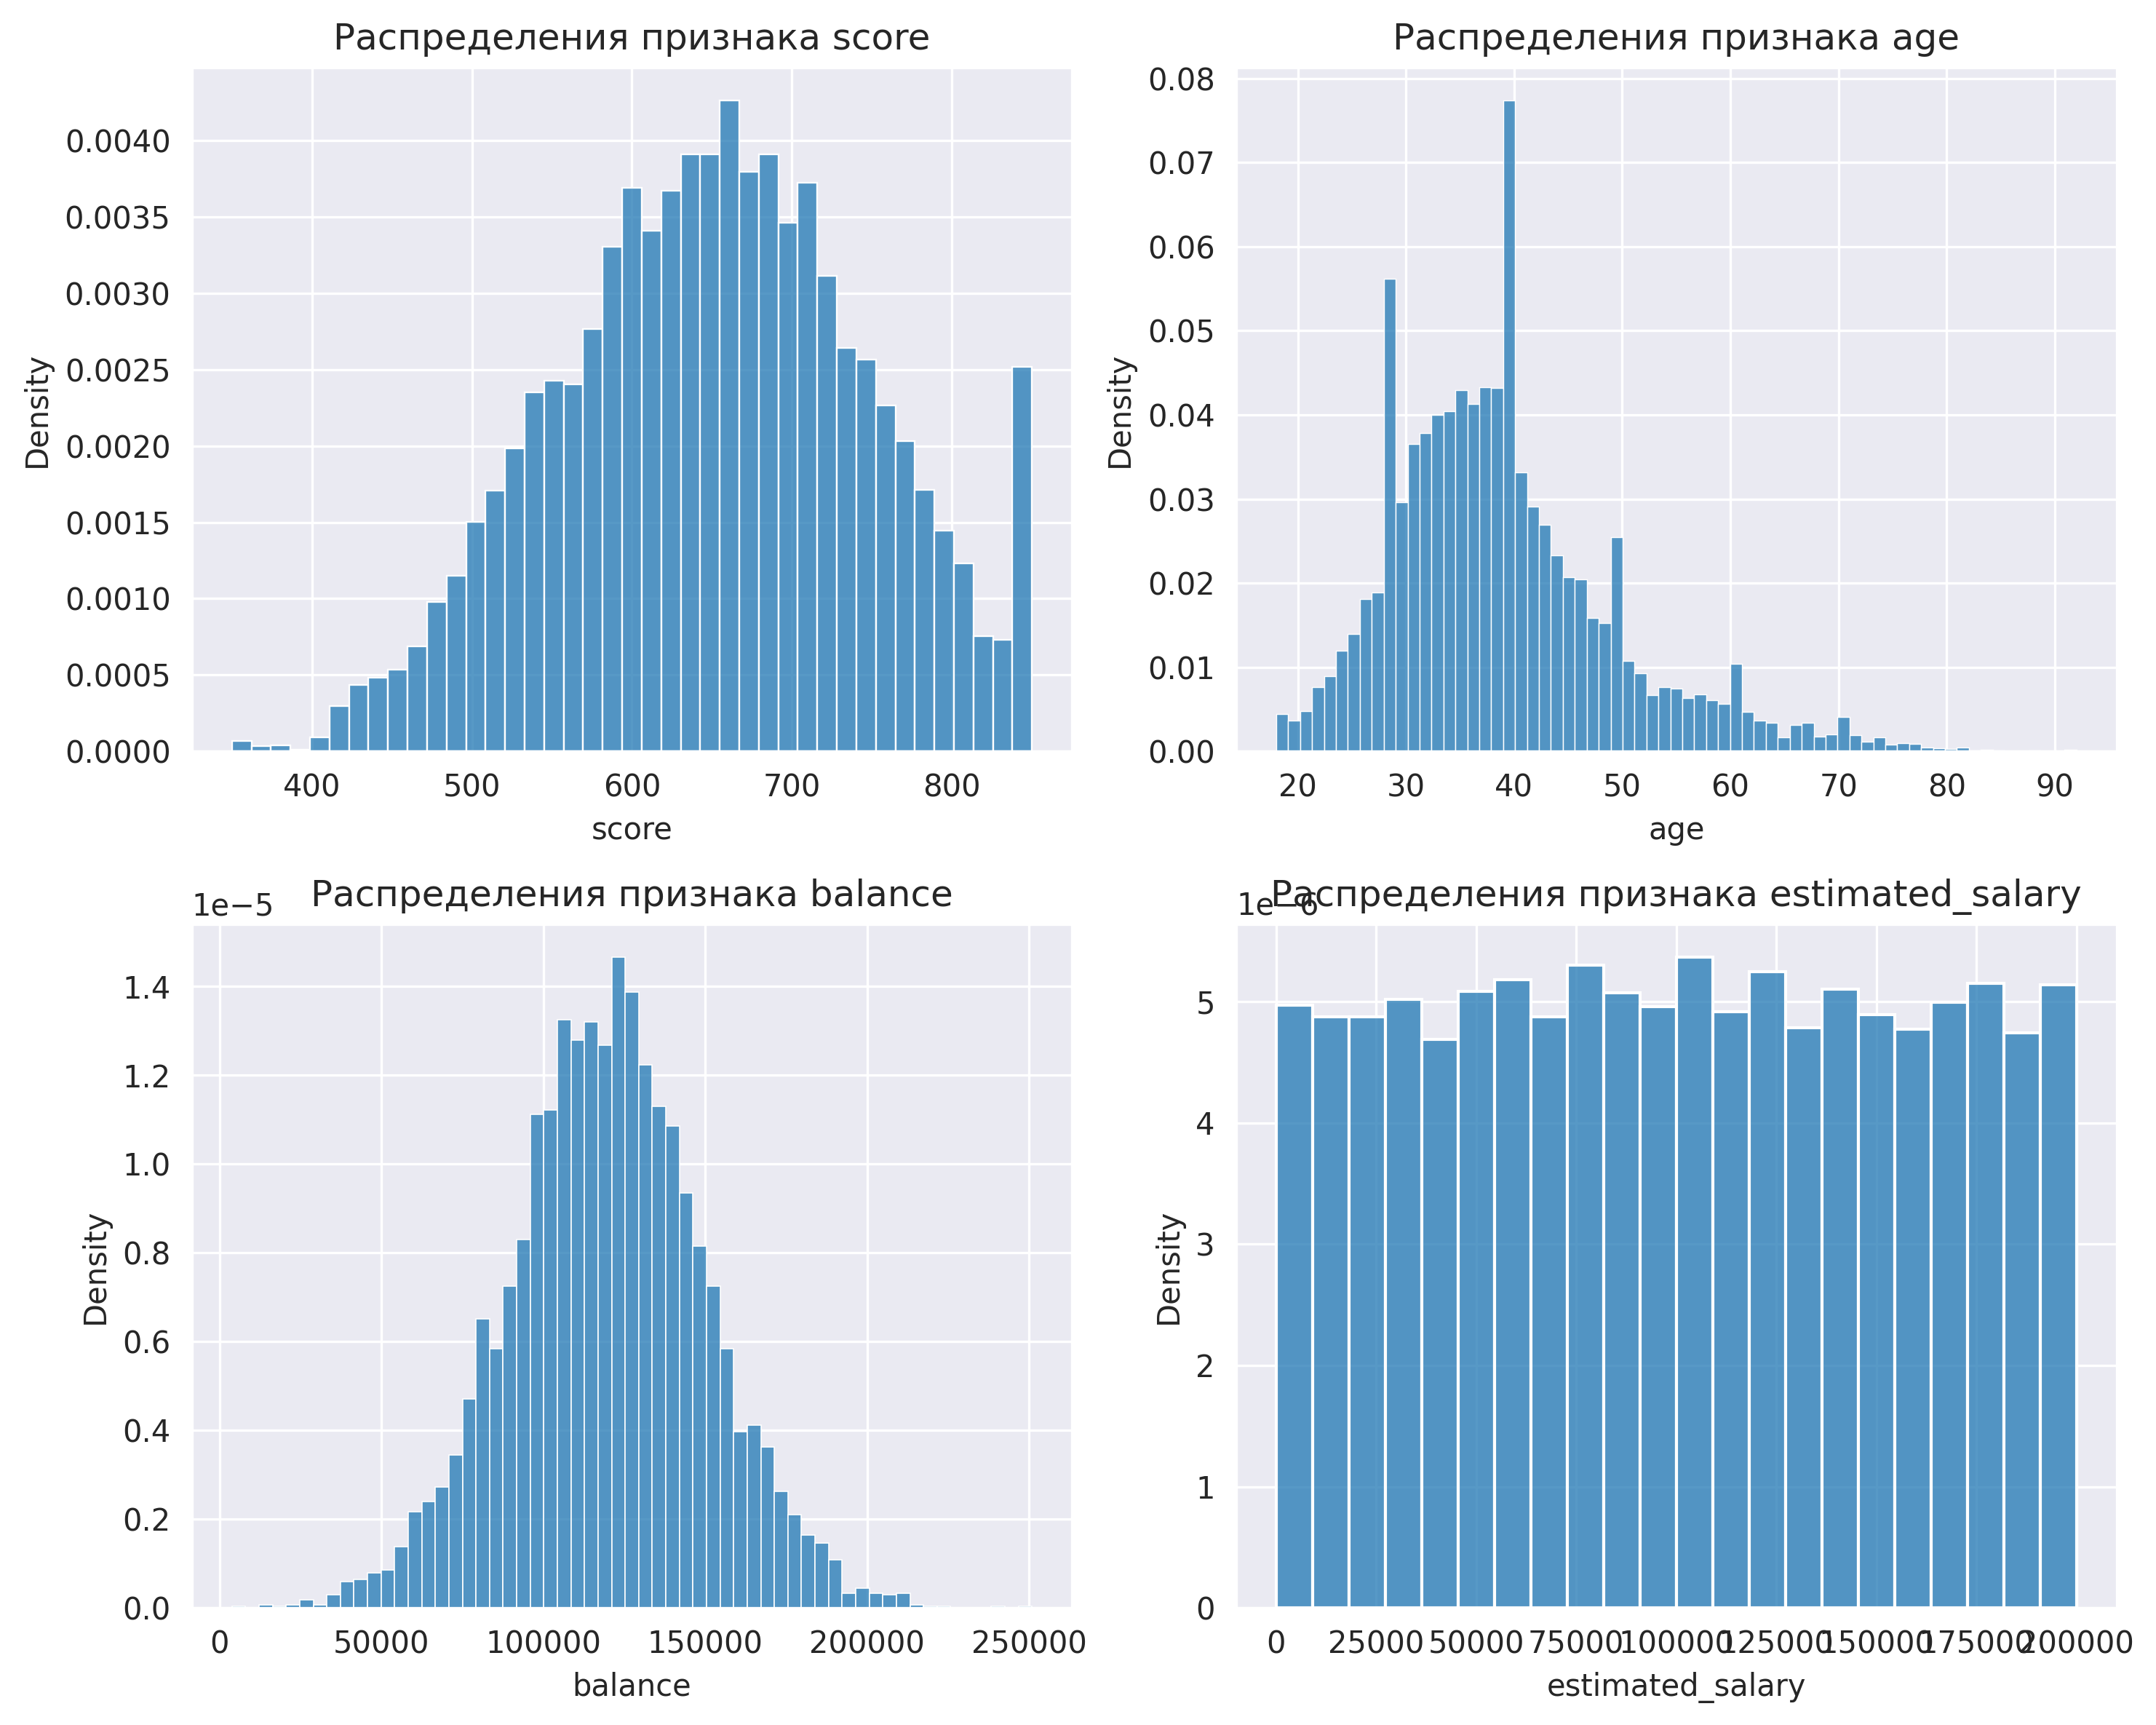

In [19]:
sns.set_style("darkgrid")
column_list = ['score', 'age', 'balance', 'estimated_salary']

fig, axs = plt.subplots(len(column_list) // 2, 2)
fig.set_size_inches(10, 8) 
fig.set_dpi(300)

new_axs = [item for sublist in axs for item in sublist]

for i, column in enumerate(column_list):
    sns.histplot(data=df, x=column,  stat='density', common_norm=False, palette="Blues_d",  ax=new_axs[i])
    new_axs[i].set_title('Распределения признака {}'.format(column))

plt.tight_layout()
plt.show();

**Вывод:**

- распределение кредитного рейтинга возраста и баланса походит на нормальное, хотя имеются выбросы ;
- распределение рассчитанного дохода скорее всего равномерное;
- график подтверждает, что большинство клиентов имеют высокий кредитный рейтинг.

### Корреляционный анализ

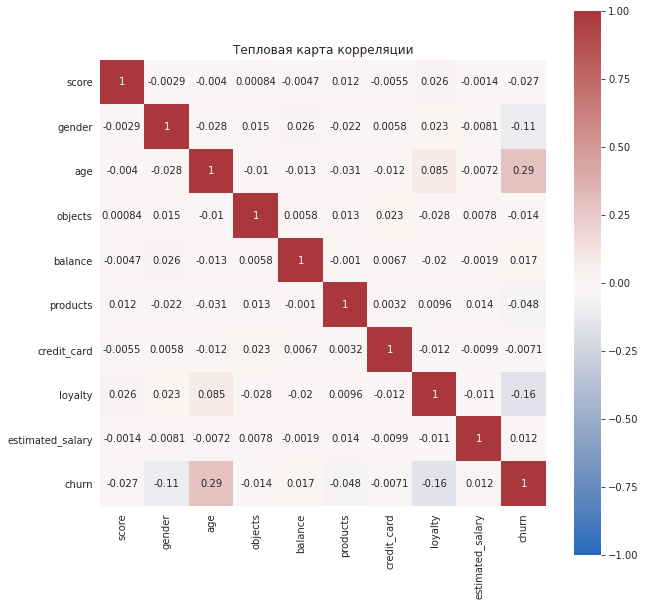

In [20]:
corr = df.drop('user_id', axis=1).corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr,
            vmin=-1,
            vmax=1,
            square=True,
            annot=True,
            cmap='vlag')

plt.title('Тепловая карта корреляции')
plt.show()

Все признаки незначительно коррелируют друг с другом

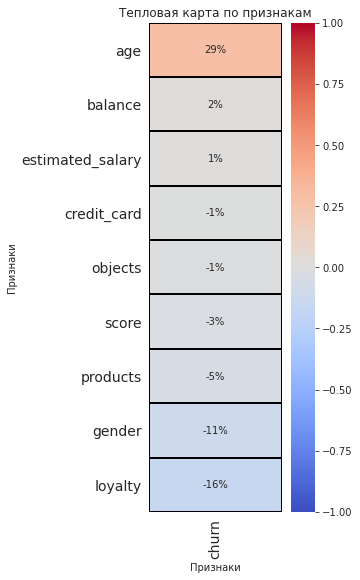

In [21]:
corr = df.drop('user_id', axis=1).corr()
plt.figure(figsize=(3, 9))
sns.heatmap(corr.loc[:,['churn']].drop('churn').sort_values('churn', ascending=False), annot = True, fmt='.0%', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=1, linecolor='black')
plt.title('Тепловая карта по признакам')
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14, rotation=360)
plt.ylabel('Признаки')
plt.xlabel('Признаки');

На корреляционной таблице каких-то сильных линейных зависимостей не наблюдаем

interval columns not set, guessing: ['score', 'gender', 'age', 'objects', 'balance', 'products', 'credit_card', 'loyalty', 'estimated_salary', 'churn']


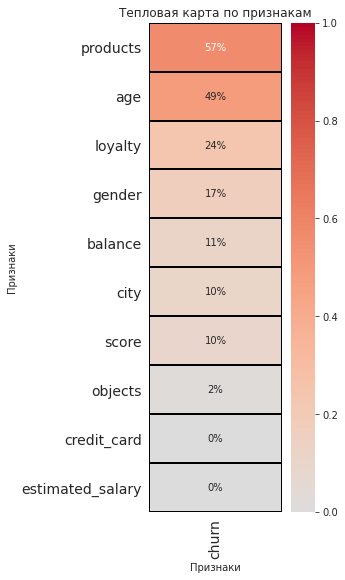

In [22]:
df_phik = df.drop('user_id', axis=1).phik_matrix()
plt.figure(figsize=(3, 9))
sns.heatmap(df_phik.loc[:,['churn']].drop('churn').sort_values('churn', ascending=False), annot = True, fmt='.0%', vmin=0, vmax=1, center= 0, cmap= 'coolwarm', linewidths=1, linecolor='black')
plt.title('Тепловая карта по признакам')
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14, rotation=360)
plt.ylabel('Признаки')
plt.xlabel('Признаки');

На phik корреляцинной таблице прослеживается связь оттока с количеством продуктов

### Анализ метрик в разрезе продуктов

In [23]:
df.groupby('products').mean().T

products,1,2,3,4
user_id,15732367.90,15734841.49,15741816.49,15719361.27
score,649.12,652.19,648.11,653.58
gender,0.55,0.55,0.44,0.37
age,39.67,37.75,43.20,45.68
objects,4.97,5.05,5.00,5.30
balance,119894.16,119660.94,119475.69,122260.61
credit_card,0.70,0.71,0.71,0.68
loyalty,0.50,0.53,0.42,0.48
estimated_salary,99487.26,100452.01,104318.13,104763.72
churn,0.28,0.08,0.83,1.00


In [24]:
df.groupby('products')['age'].count()

products
1    5084
2    4590
3     266
4      60
Name: age, dtype: int64

Клиентов, у которых нет продуктов и у кого 5 продуктов для анализа не берем, так как там малое количество клиент, анализировать их будет некорректно.

Наблюдаем большу долю оттока у клиентов, пользующихся 3-4 продуктами. Доля оттока у них составляет 29% и 63% соответственно. Несмотря на их небольшое количество следует отдельно обратить внимание на эти группы.

Построим распределения в разрезе количества потребляемых продуктов. Посколько группы 3 и 4 малочисленны, объединим их в одну и обозначим как 3.

In [25]:
df.loc[df['products'] == 4, 'products'] = 3

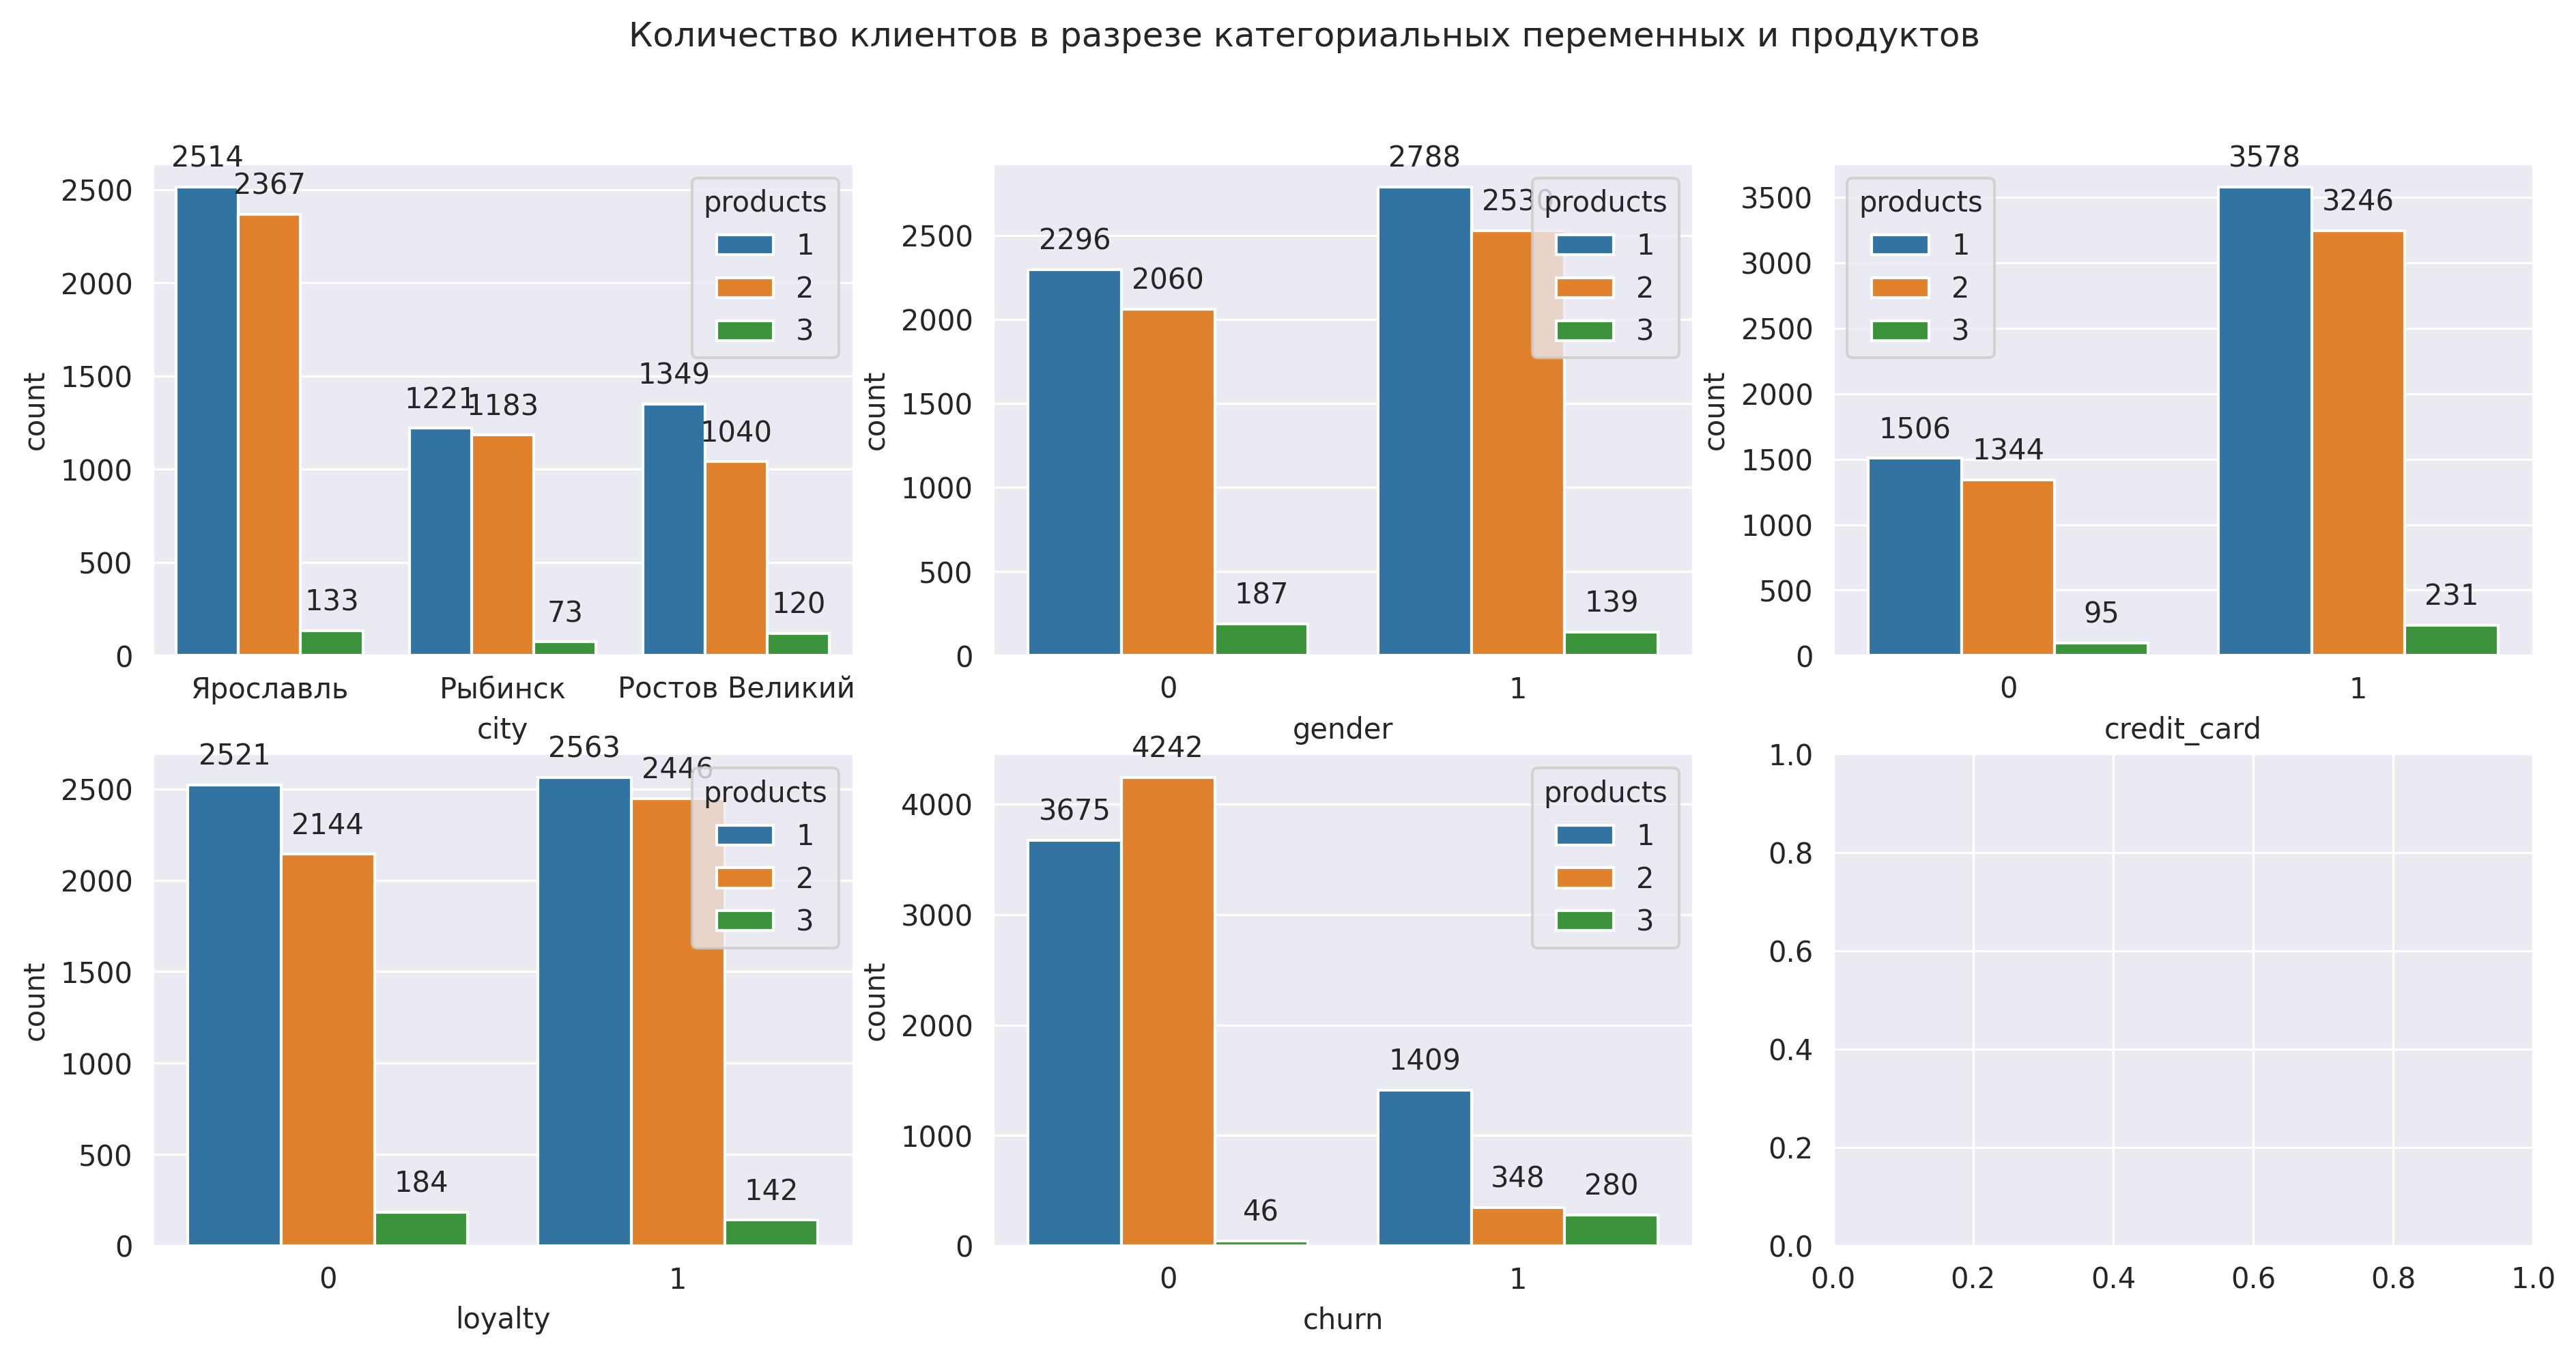

In [35]:
values = ['city', 'gender', 'credit_card', 'loyalty', 'churn']

fig, ax = plt.subplots(2, 3)
fig.set_size_inches(15, 7) 
fig.set_dpi(300)

for variable, subplot in zip(values, ax.flatten()):
    splot = sns.countplot(data=df, x=variable, hue='products', ax=subplot)
    for p in splot.patches:
        splot.annotate('{:.0f}'.format(p.get_height()), (p.get_x() + p.get_width()/2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
fig.suptitle("Количество клиентов в разрезе категориальных переменных и продуктов");
fig.show('png')

Ключевая метрика для нас - это отток, поэтому смотрим графики с учетом того, что лучшая группа по оттоку - это 2, худшая 3.

- в группе 2 чуть чаще пользуются приложением;
- меньше всего клиентов с двумя продуктами проживают в Ростове Великом;
- 1-2 продуктами чаще пользуются мужчины, 3 - 4 женщины;
- во всех группах пользователей кредитных карт больше чем клиентов не имеющих данного продукта.

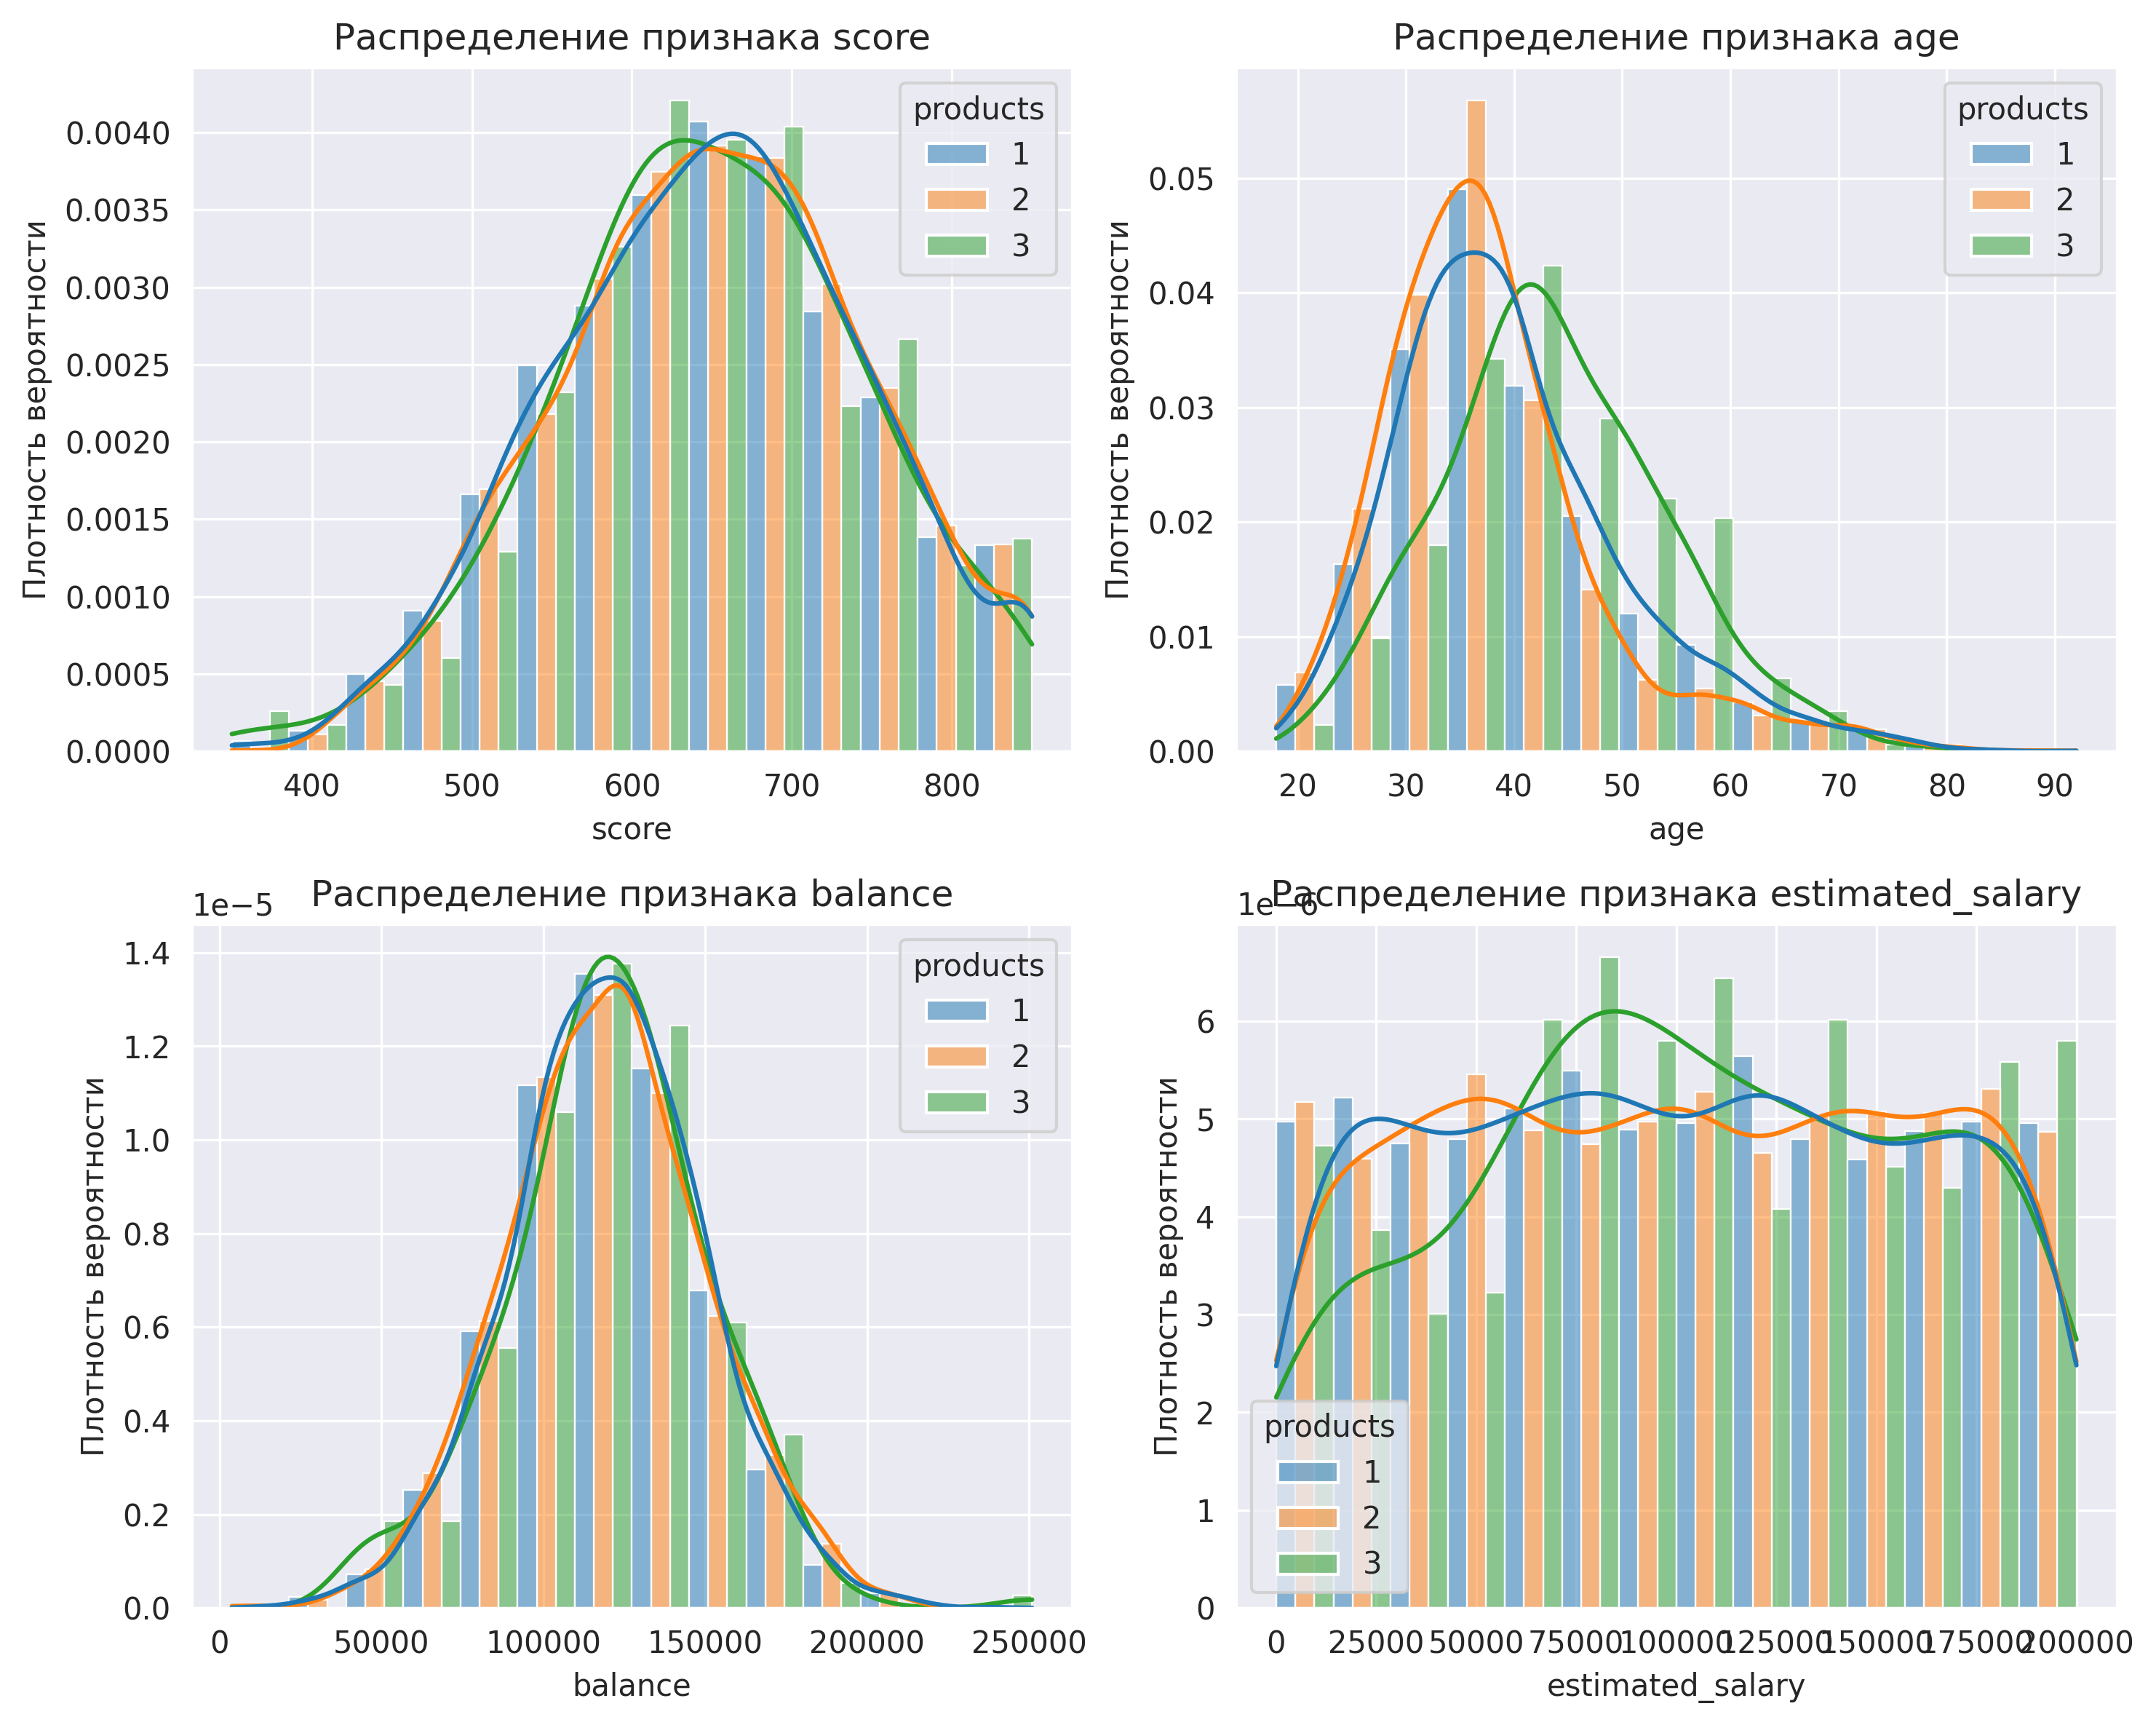

In [27]:
columns_list = ['score', 'age', 'balance', 'estimated_salary']

fig, axs = plt.subplots(len(columns_list) // 2, 2)
fig.set_size_inches(10, 8) 
fig.set_dpi(300)

for i, column in enumerate(columns_list):
    sns.histplot(
        data=df.assign(products=df.products.clip(1,3)), 
        x=column,  
        stat='density', 
        hue = 'products', 
        multiple='dodge',
        palette='tab10',
        kde=True, 
        common_norm=False,
        bins=14,
        ax=axs.ravel()[i])\
    .set(title = f'Распределение признака {column}', ylabel="Плотность вероятности")

plt.tight_layout()

plt.show();

- в группе с 3-4 продуктами люди более старшего возраста;
- клиенты с двумя продуктами и минимальным чаще попадают в возрастной сегмент 30-40 лет;
- распределение признака дохода равномерное, остальных признаков близко к нормальному.


### Отток. Портет клиента

Посмотрим на средние значения в разрезе отттока.

In [28]:
df.groupby('churn').mean().T

churn,0,1
user_id,15733903.88,15732787.96
score,651.85,645.35
gender,0.57,0.44
age,37.41,44.84
objects,5.03,4.93
balance,119535.86,120746.97
products,1.54,1.45
credit_card,0.71,0.70
loyalty,0.55,0.36
estimated_salary,99738.39,101465.68


На первый взгляд можно отметить следующее:

- женщины более склонны к оттоку чем мужчины;
- средний возраст отточного клиента выше - около 44-45 лет;
- доля оттока у владельцев кредитных карт и тех, кто ей не пользуется мало различаются.

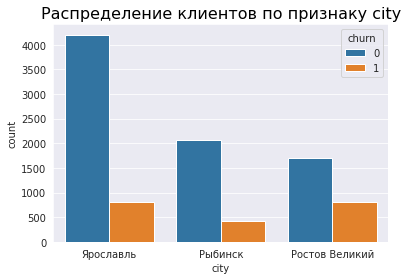

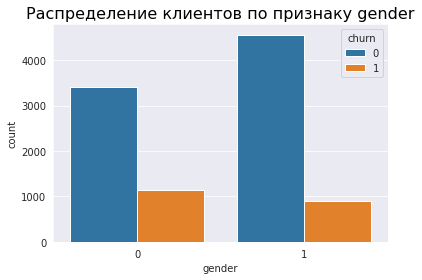

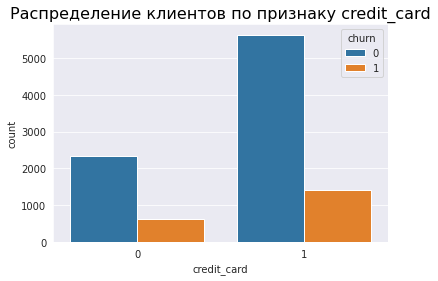

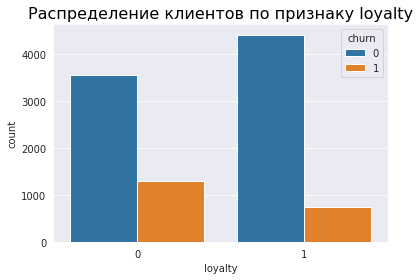

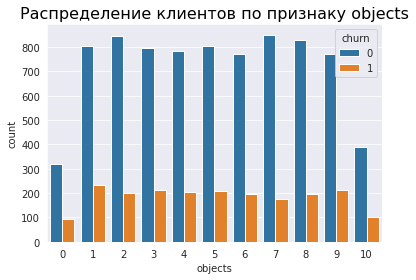

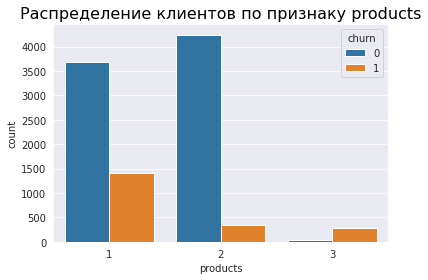

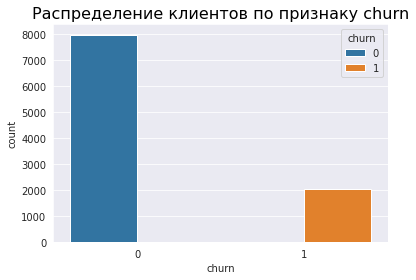

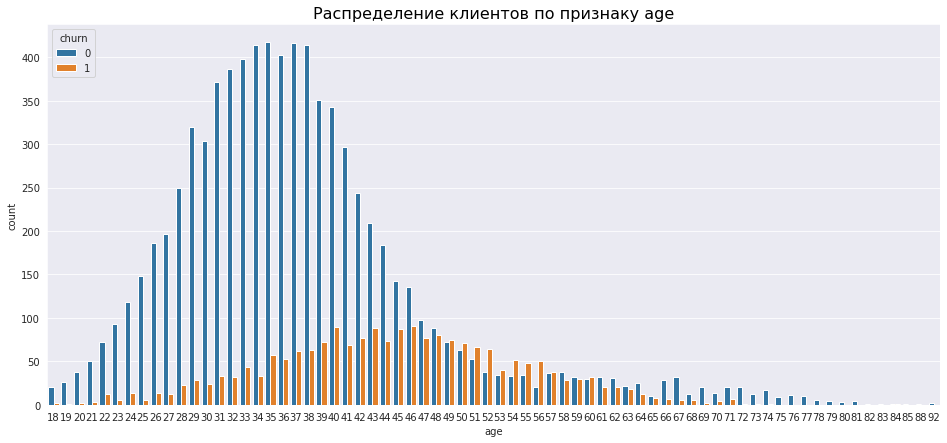

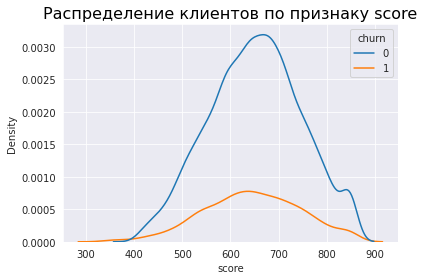

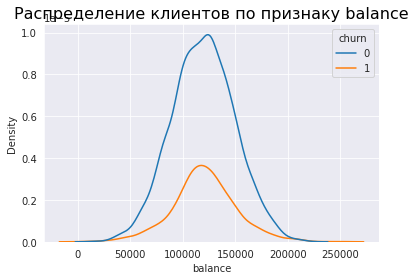

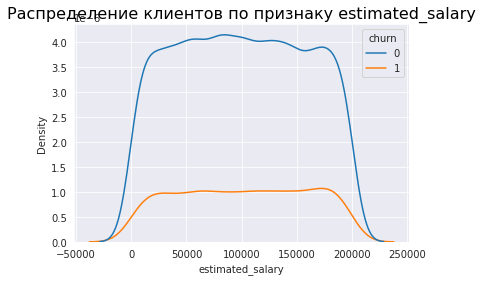

In [29]:
def tables(data, hue=None):
    #дискретные значения
    for column in ['city','gender', 'credit_card', 'loyalty', 'objects', 'products', 'churn']:
        ax = sns.countplot(data=data, x=column, hue=hue);
        plt.title(f'Распределение клиентов по признаку {column}', fontsize = 16, color = 'black')
        plt.show()
    
    plt.figure(figsize=(16,7))
    sns.countplot(data=data, x='age', hue=hue);
    plt.title('Распределение клиентов по признаку age', fontsize = 16, color = 'black')
    plt.show()

    #непрерывные значения
    for column in ['score',  'balance', 'estimated_salary']:
        sns.kdeplot(data=data, x=column, hue=hue);
        plt.title(f'Распределение клиентов по признаку {column}', fontsize = 16, color = 'black')
        plt.show()

tables(df, hue='churn')  

- самая высокая доля оттока в Ростове Великом;
- доля оттока среди тех кто совершает действия в приложении заметно ниже чем среди малоактивных клиентов;
- несмотря на то, что клиентов с 3-4 продуктами мало, доля оттока в них выше доли удержания;
- женщины чуть более склонны к оттоку;
- высокая доля оттока у клиентов с одним продуктом;
- возраст примерно 42 и выше;
- остаток на балансе выше 100 тысяч.


Отток клиентов по всем признакам на одной графике не информативен, каждый признак рассмотрим отдельно

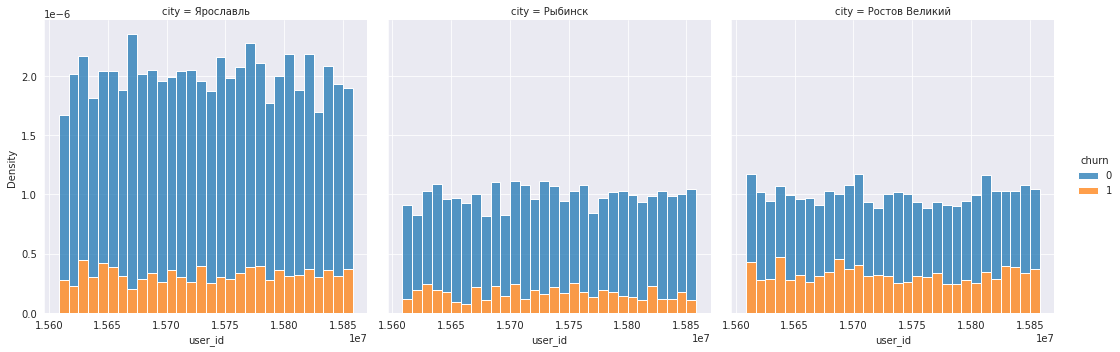

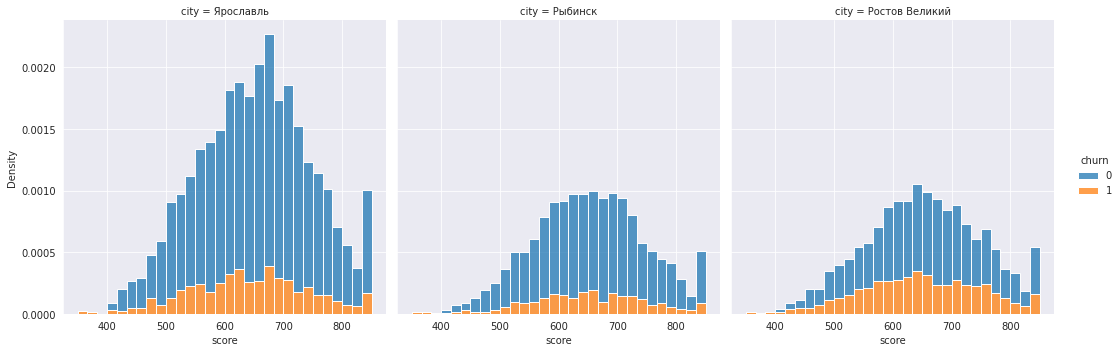

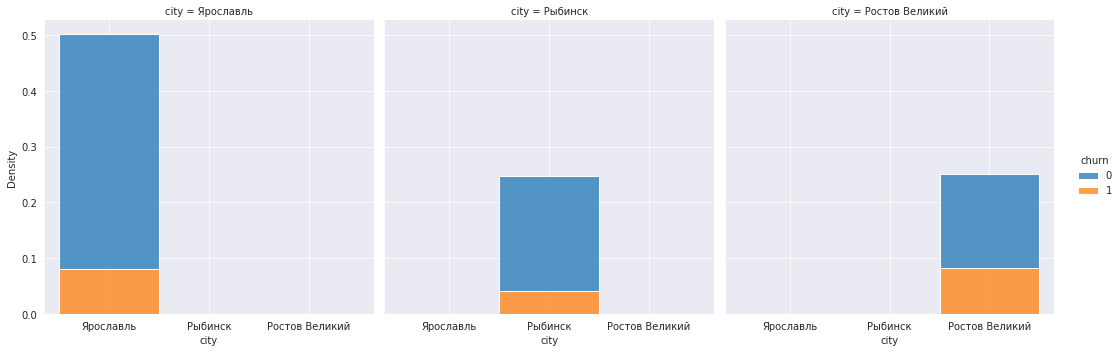

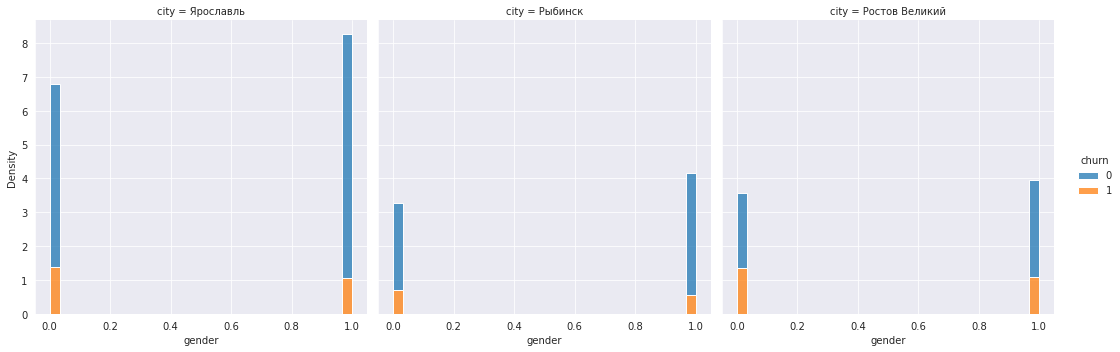

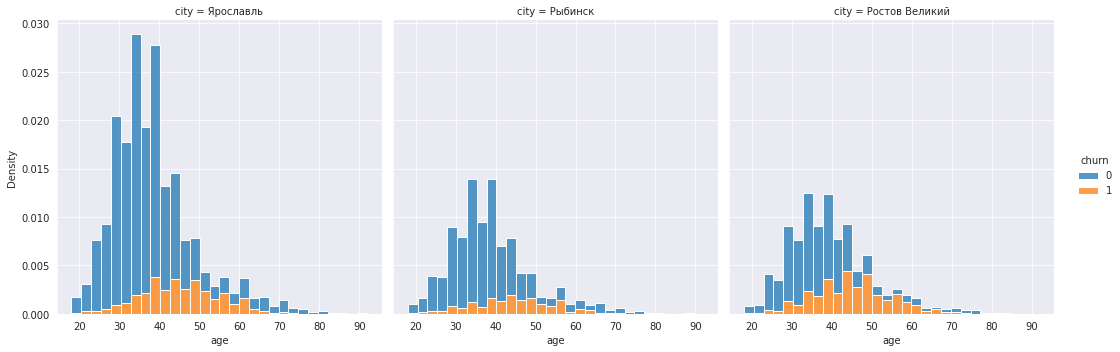

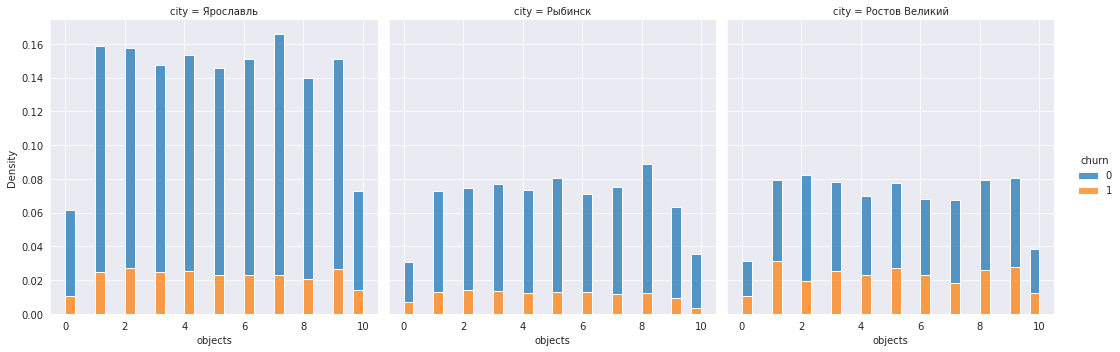

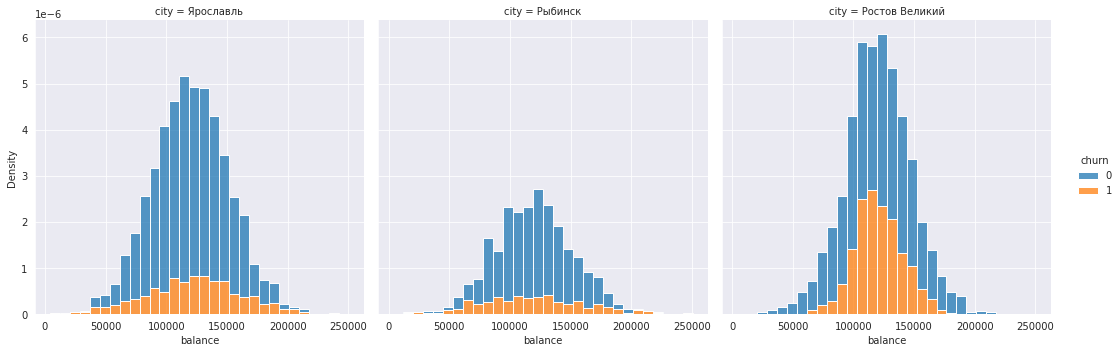

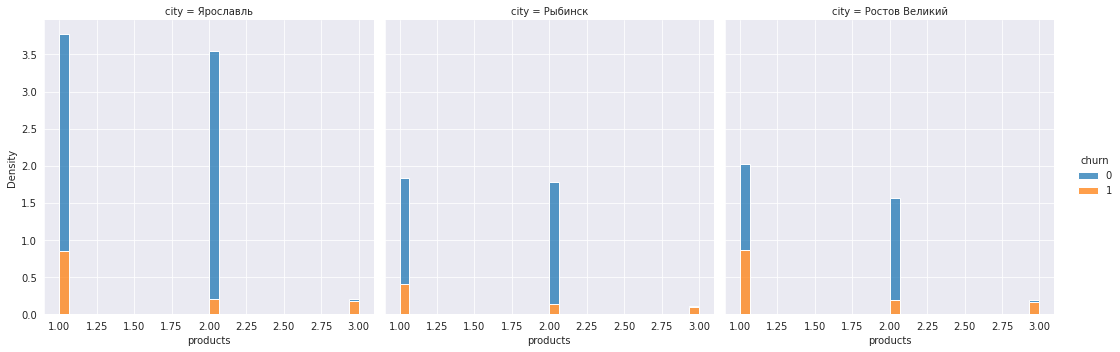

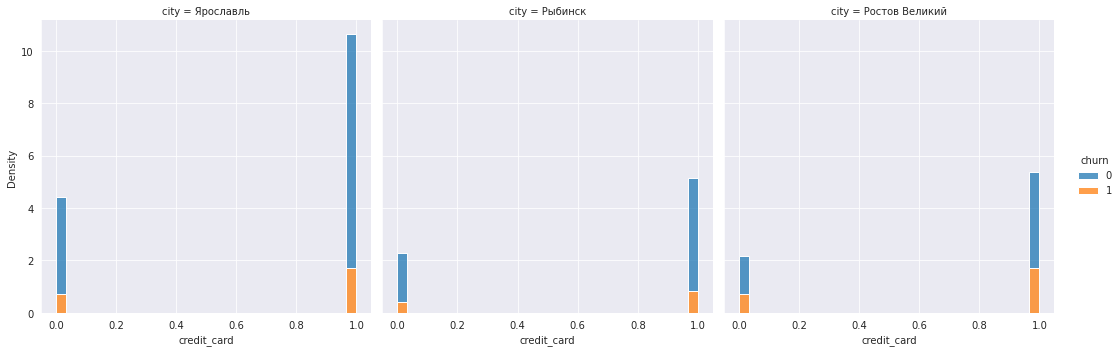

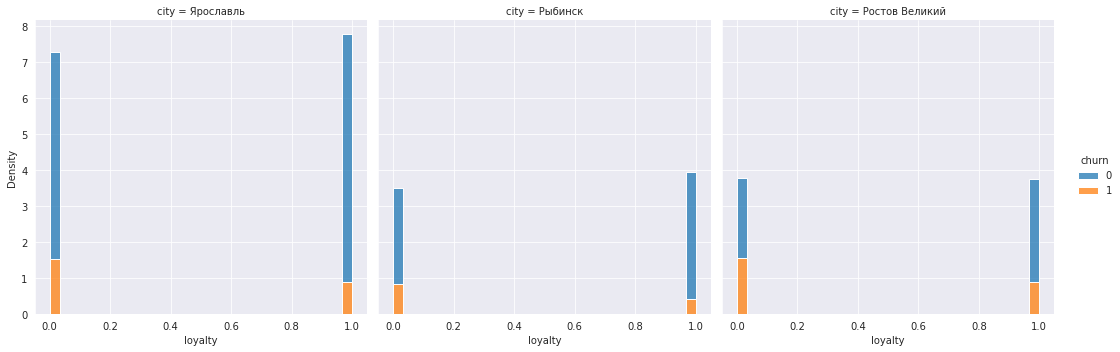

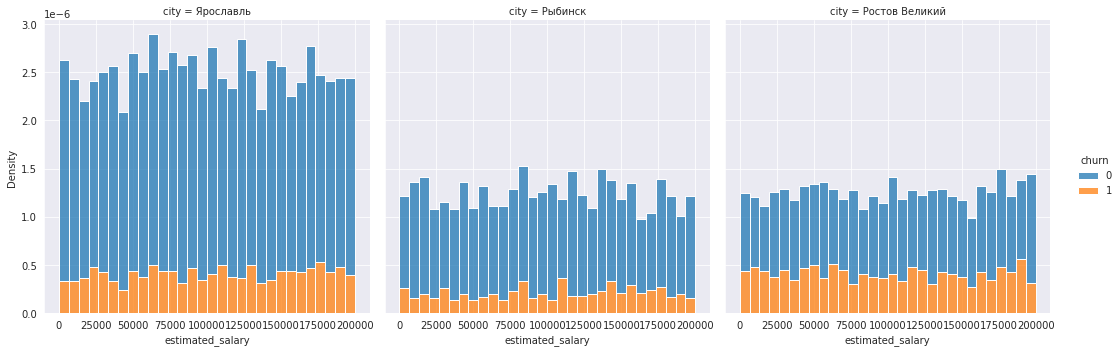

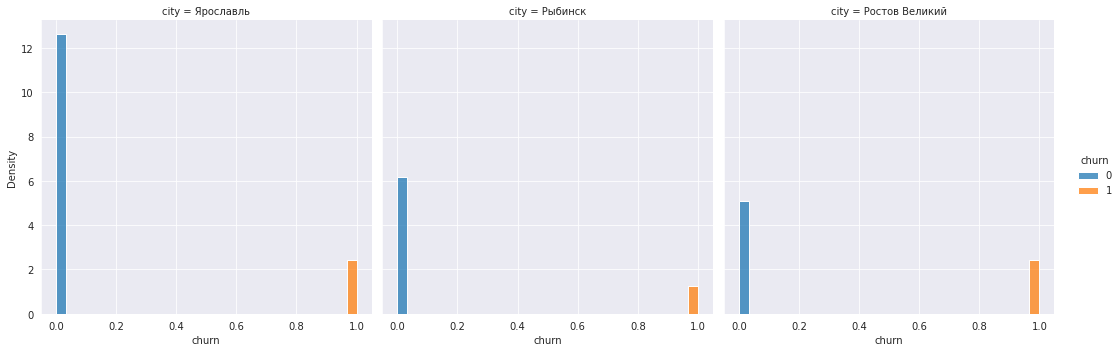

In [30]:
# распределение признаков в в размере города и оттока клиента

for i in df.columns:
    sns.displot(x=i, bins=30,
                col='city', hue='churn',
                kde=False, 
                stat="density", 
                multiple="stack",
                data=df)

**Вывод:**

Наименьшая доля оттока - в Ярославле, наибольший - в Ростове (50% от количества постоянных клиентов). Женщины более склонны к уходу- и в абсолютном, и в относительном выражении. Пользователи кредитных карт уходят/остаются почти в одинаковой пропорции, активные клиенты с большей долей вероятности останутся с банком.

Клиенты, которые пользуются двумя продуктами- самая многочисленная группа по количеству преданных банку клиентов, а доля оттока у этой категории самая низкая. Тех, кто пользуется одним продуктом, немногим меньше, но доля оттока у них больше. Пользователи с 3-4 продуктами за небольшим исключением полностью отточны.

Больше всего клиентов- это люди среднего возраста, 30-40 лет, они составляют основную массу тех, кто остается с банком. Наиболее склонны к оттоку лица 44-45 лет.

Кредитный рейтинг, остаток на балансе и заработная плата клиента не оказывает влияния на принятие решения об уходе из банка.

## Проверка гипотез

### Гипотеза №1 Средний доход влияет на отток

Сформулируем первую гипотезу.

**H0:Средний доход отточных и неотточных клиентов равен**

**H1:Средний доход отточных и неотточных клиентов различается** 

α=5% критический уровень статистической значимости.

In [31]:
no_churn = df.query('churn == 1')['estimated_salary']
churn = df.query('churn == 0')['estimated_salary']

alpha = 0.05
results = st.ttest_ind(
    no_churn, 
    churn,
    equal_var=True)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.22644042802223352
Не получилось отвергнуть нулевую гипотезу


Нет основания отвергать нулевую гипотезу, считаем, что доход отточных и неотточных клиентов равен

### Гипотеза №2 Средний возраст влияет на отток

Сформулируем вторую гипотезу.

**H0:Средний возраст в группах с оттоком и без одинаковый**

**H1:Средний возраст в группах с оттоком отличается от среднего возраста в группе без оттока**

α=5% критический уровень статистической значимости.

In [32]:
no_churn = (df
                           .query('churn == 0')
                           .pivot_table(index = 'user_id', values = 'age')
                      )
churn = (df
                           .query('churn == 1')
                           .pivot_table(index = 'user_id', values = 'age')
                      )
  
print('cредний возраст (churn): ', churn['age'].mean().round())
print('cредний возраст (no churn): ', no_churn['age'].mean().round())

alpha = 0.05
results = st.ttest_ind(
    no_churn, 
    churn)
    
print('p-значение: ', results.pvalue)
    
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

cредний возраст (churn):  45.0
cредний возраст (no churn):  37.0
p-значение:  [1.23993131e-186]
Отвергаем нулевую гипотезу


Есть основания отвергнуть нулевую гипотезу, считаем, что средний возраст отточных и неотточных клиентов различается

**Вывод:**

По итогу проверок гипотез можем сказать:

- средний доход отточных и неотточных клиентов равен;
- средний возраст отточных и неотточных клиентов различается

## Сегментация

Итак, к стратегически важным можем отнесте следующие параметры: gender, age, city. Посмотрим доли клиентов с потенциально опасным значением данных признаков от общего числа клиентов.

In [33]:
print ('Женщины', df.query("gender == 0").shape[0]/df.shape[0]*100, '%')
print ('Возраст больше 42', round(df.query("age>42").shape[0]/df.shape[0]*100,2), '%')
print ('Ростов', round(df.query("city == 'Ростов Великий'").shape[0]/df.shape[0]*100,2), '%')

Женщины 45.43 %
Возраст больше 42 28.94 %
Ростов 25.09 %


Да имеем огромные доли вплоть до половины датасета. Посчитаем долю оттока в каждой из этих групп.

churn
0   0.80
1   0.20
Name: churn, dtype: float64

/tmp/ipykernel_628/4147445174.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_segment['size'][i] = value.shape[0]
/tmp/ipykernel_628/4147445174.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_segment['avg_churn'][i] =  value.query("churn==1").shape[0] / value.shape[0]
/tmp/ipykernel_628/4147445174.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_segment['size'][i] = value.shape[0]
/tmp/ipykernel_628/4147445174.py

,name,size,avg_churn
0,женщины,4543,0.25
1,старше 42,2894,0.42
2,из Ростова,2509,0.32


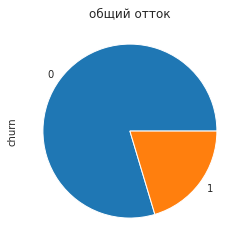

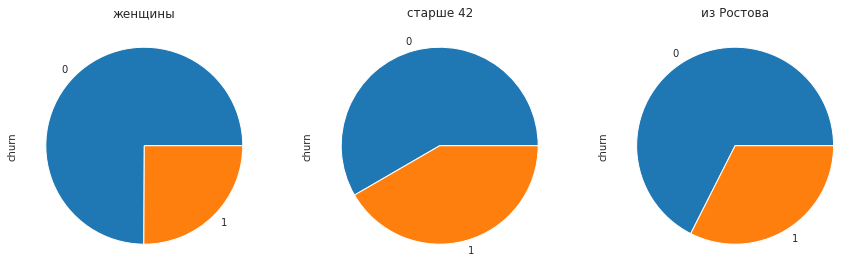

In [34]:
df_gender = df.query("gender == 0")
df_age = df.query("age>42")
df_city = df.query("city == 'Ростов Великий'")

part_churn = df.groupby('churn')['churn'].count() / df.shape[0]
display (part_churn)


part_churn.plot(kind = 'pie').set(title = 'общий отток')
values = [df_gender, df_age, df_city]
title_list = ['женщины', 'старше 42', 'из Ростова']
fig, axs = plt.subplots(1, len(values), sharey = False, figsize = (15,5))

for i, value in enumerate(values):
    part_churn = value.groupby('churn')['churn'].count() / value.query("churn==1")['age'].count()
    part_churn.plot(kind = 'pie', ax=axs[i]).set(title = title_list[i]) 
    
df_segment = pd.DataFrame()
df_segment['name'] = title_list
df_segment['size'] = 0
df_segment['avg_churn'] = 0.0
for i, value in enumerate(values):
    df_segment['size'][i] = value.shape[0]
    df_segment['avg_churn'][i] =  value.query("churn==1").shape[0] / value.shape[0]
    
df_segment

Имеем три сегмента с крайне высоким оттоком

## Вывод и рекомендации

**Вывод:**

Представленные для анализа данные содержат информацию о 10000 клиентах банка и признаках, характеризующих их поведение. В процессе предварительной обработки данных:

- исправлены нарушения стиля в наименованиях столбцов;

- заменены значения стоблца Gender с "Ж" на 0, с "М" на 1;

- проанализированы значения столбца Balance для принятия решения о работе с пропусками данных, которые составли 36.17% от общего количества данных (всего 3617 пропусков). Пропуски во избежание искажений анализа оставлены без изменений

- проведена проверка на дубликаты.

**Результаты исследования:**

Чаще всего в отток попадают:

- женщины;
- клиенты в возрасте 42-ух лет и выше;
- лица проживающие в Ростове.

**Проверены две статистические гипотезы**

Можно утверждать, что:

- средний доход отточных и неотточных клиентов равен;
- средний возраст отточных и неотточных клиентов различается.

**Рекомендации:**

- Увеличивать лояльность, привлекать клиентов к более активному использованию приложения/продуктов банка.
- Предлагать дополнительные продукты клиентам с одним продуктом.
- Поддерживать активность и лояльность клиентов с двумя продуктами. Уведомлять о спецпредложениях по кредитной/дебетовой карте, рефинансированию и другим имеющимся у клиента продуктам.
- Клиенты с тремя продуктами слонны к оттоку, стоит разобраться с третьим продуктом и улучшить его качество.
- Провести исследование и разобраться в причинах, почему в филиале в Ростове клиенты закрывают все продукты.

Ссылка на презентацию:https://drive.google.com/file/d/1Kli8rB_fMFaN--0jyTKZ2E_DeVylkGCp/view?usp=sharing

Ссылка на дашборд: https://public.tableau.com/app/profile/.40512706/viz/2_16861439515570/Sheet2?publish=yes